# Variable Xi Invariance

## Intro
* **Date**: 1/6/2021
* **What**: Basically, I'm doing ema invariance with reconstruction-based training, but I'm using a smaller learning constant for the neurons that aren't "on".  
* **Why**: Well, because invariance hasn't worked, and I think this just might.  Basically if I do reconstruction learning with a uniform learning constant, the invariant neurons learn to ignore irrelevant neurons.  The bad thing?  Some sparse features are entirely left out, and that's just no good.  And if I do reconstruction learning only on the neurons that are "on," the invariant layer learns *incredibly slowly*. Ain't nobody got time for learning that slow.  So basically, I'm trying to take the best things from full-reconstruction learning, and do it in a way where sparse features aren't disregarded.
* **Hopes**: I really, really hope that all the sparse features will be represented by invariant neurons, and that the sparse features are well-grouped.
* **Limitations**: Well, invariance hasn't really worked out that well so far.  I'm not sure what'll break, but I'm sure it'll find a way.

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

r_l = 1000 # Length of the ribbon
m_sl = 28 # Side length of each images

r_s = 0 # Starting index of the ribbon

ribbon = np.zeros((m_sl, r_l * m_sl))

for x in range(r_l):
    ribbon[:, m_sl * x : m_sl * (x + 1)] = x_tr[x + r_s]
    
t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 3000

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [17]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 100_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_tapestry = img_array.reshape(-1, sl ** 2)
gp_tapestry = cp.asarray(ts_tapestry)

<IPython.core.display.Javascript object>


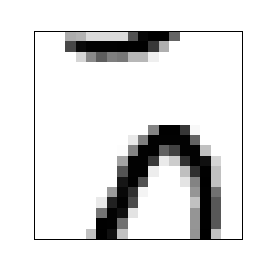

In [10]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [18]:
img_count = 100_000
imgs = []

del_t = 1

for i in range((r_l - 1) * m_sl):    
    imgs.append(ribbon[:, i : i + m_sl])
    
img_array = np.array(imgs)
ts_ribbon = img_array.reshape(-1, m_sl ** 2)
gp_ribbon = cp.asarray(ts_ribbon)

<IPython.core.display.Javascript object>


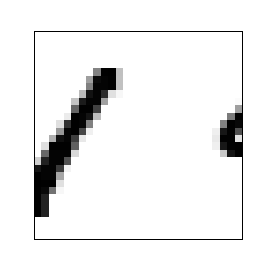

In [12]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

## Analysis Dialog

Aight fam, who's going to carry the mother-fucking boats?

<IPython.core.display.Javascript object>


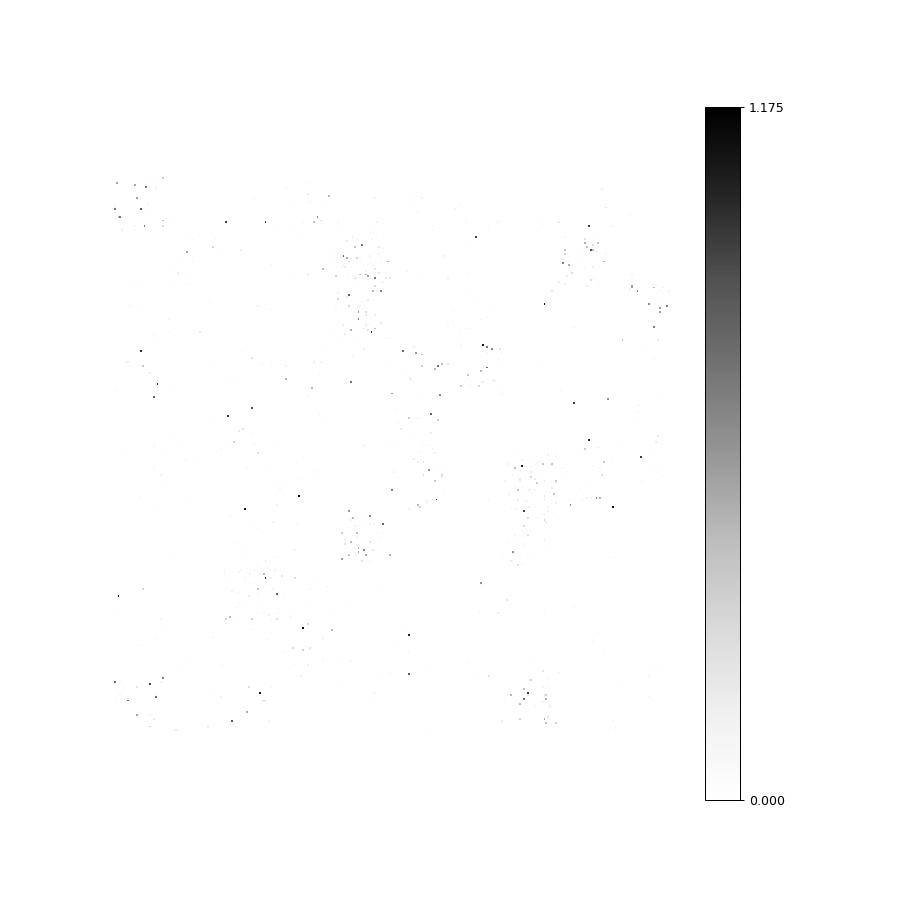

100%|██████████| 10000/10000 [00:09<00:00, 1068.76it/s]


In [19]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = sl ** 2

n_w = 6 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.03

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 0.5
leta = 0.01
seta = 0.001

for ep in range(Nep):
    inputs = gp_tapestry
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
#         print(sw.shape, v.shape)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T

    if (ep // 2) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Did it work?  Difficult to tell.

<IPython.core.display.Javascript object>


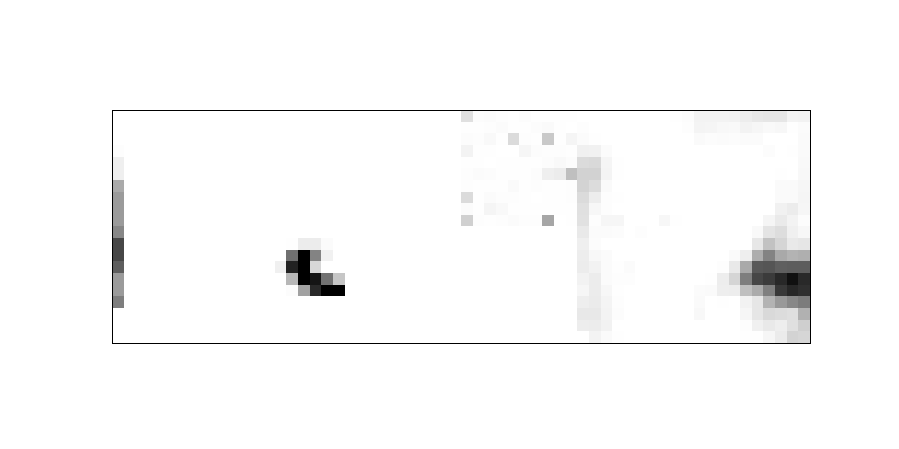

100%|██████████| 500/500 [00:01<00:00, 476.01it/s]


In [21]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_tapestry[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, let's check out neuron representation.

<IPython.core.display.Javascript object>


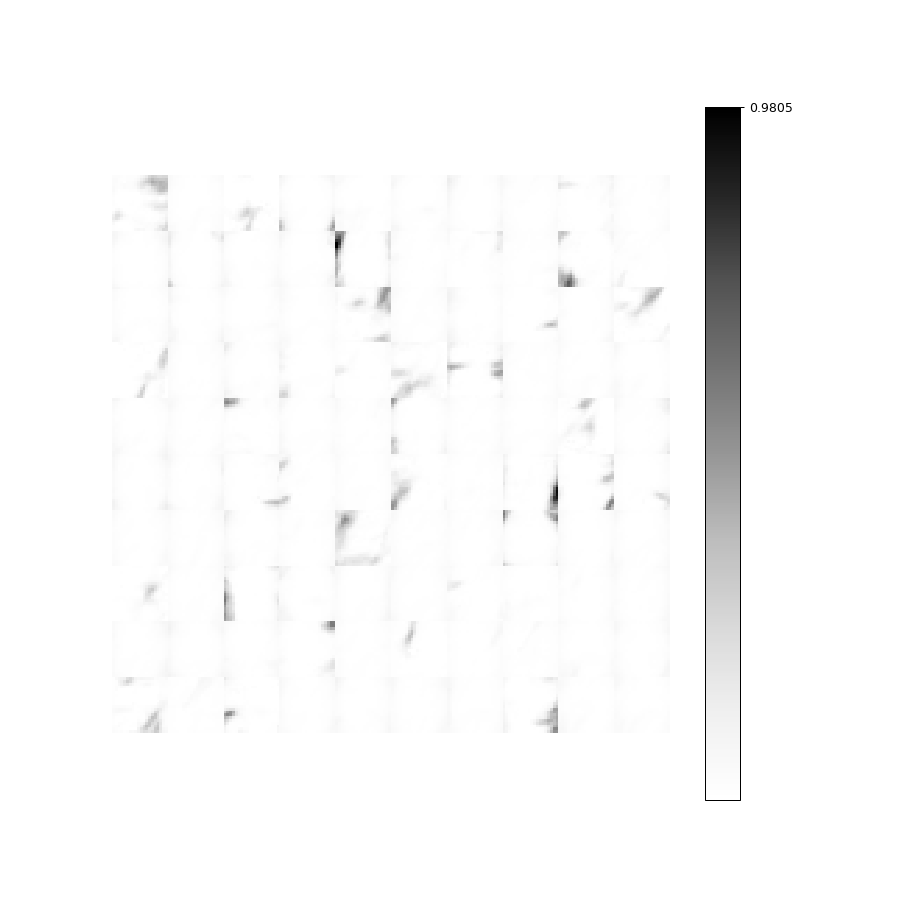

In [23]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 20, fig)

<IPython.core.display.Javascript object>


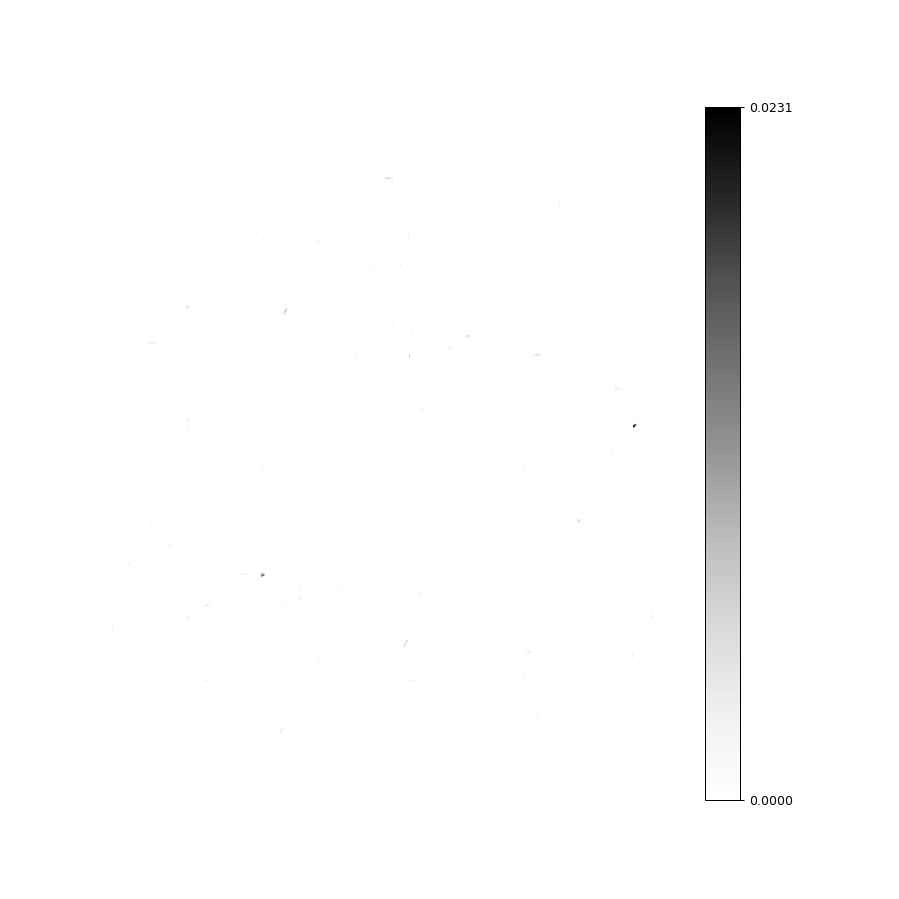

In [28]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[15].reshape(-1, 1)).get(), Kx, Ky, 20, fig)

<IPython.core.display.Javascript object>


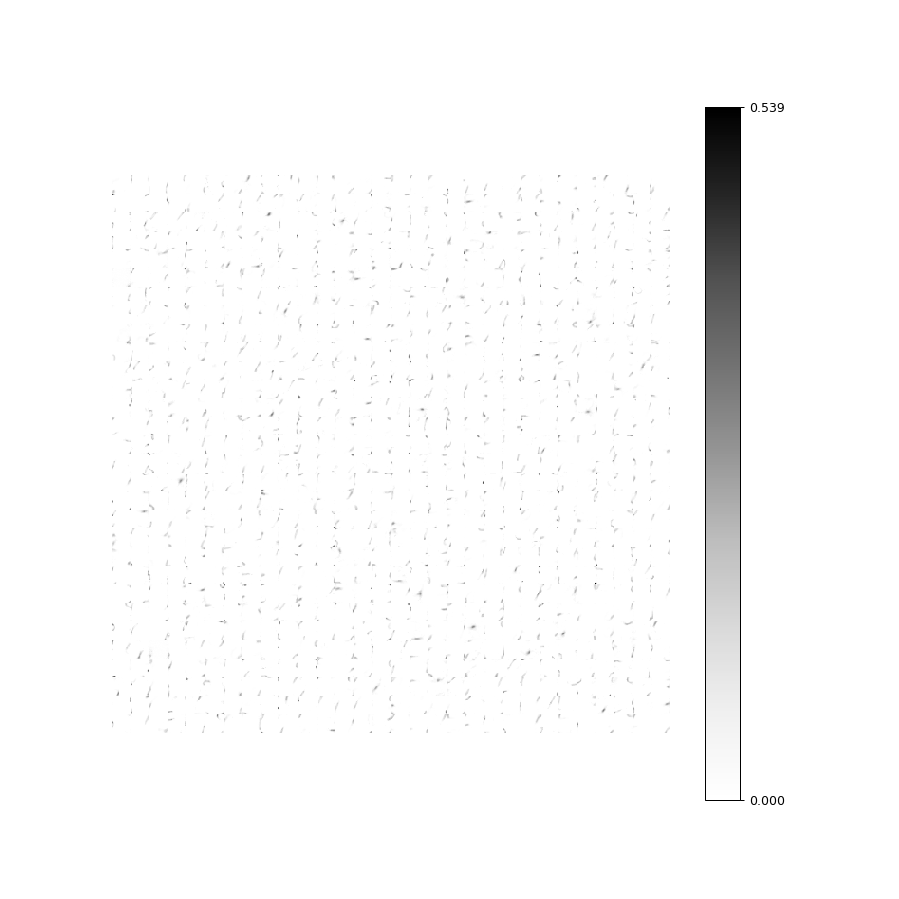

In [29]:
fig = plt.figure(figsize=(10,10))

draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


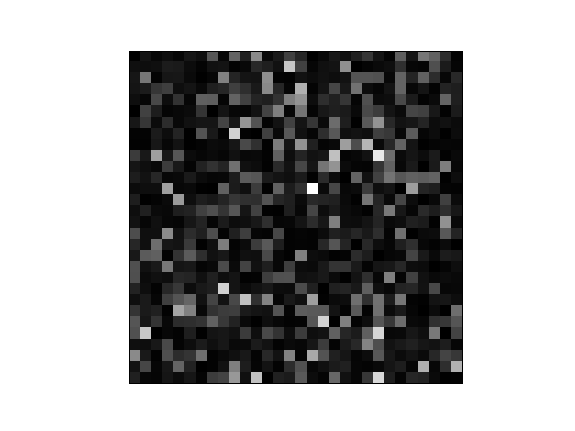

In [31]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

That's not great.  I think I'm going to use fewer winners, and see what happens.

<IPython.core.display.Javascript object>


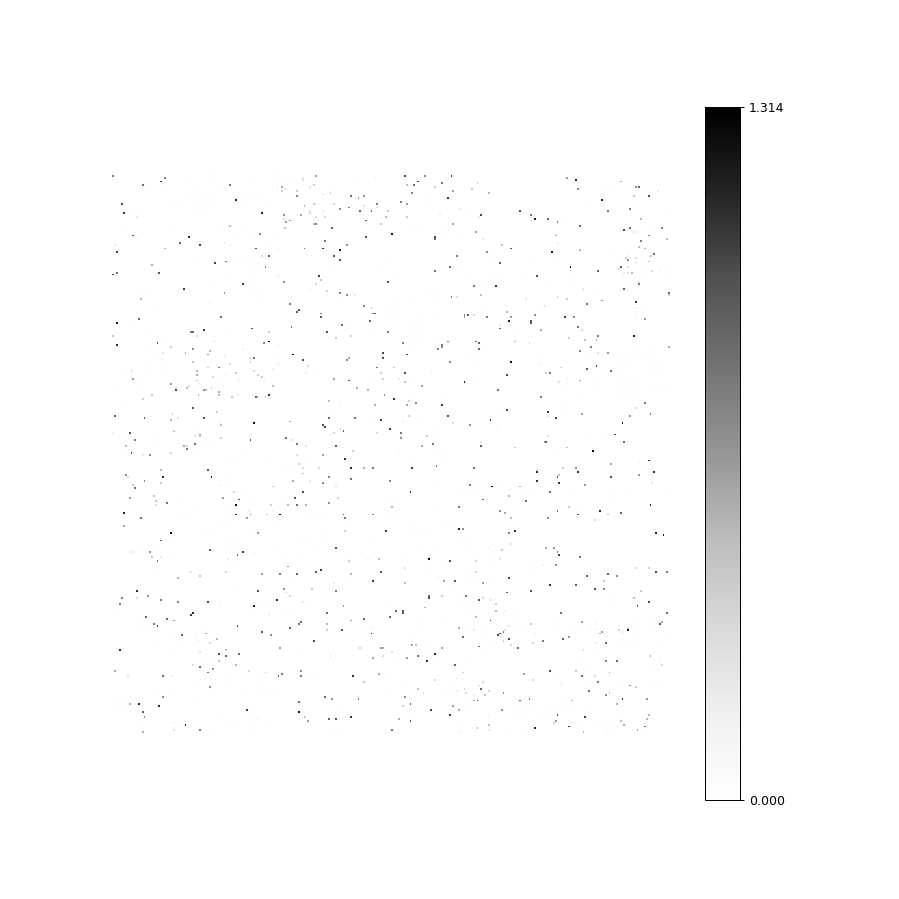

100%|██████████| 10000/10000 [00:09<00:00, 1056.70it/s]


In [34]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = sl ** 2

n_w = 3 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.03

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 0.5
leta = 0.05
seta = 0.005

for ep in range(Nep):
    inputs = gp_tapestry
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
#         print(sw.shape, v.shape)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

I upped `leta` and `seta`, and I'm pretty happy about the invariant feature prototypes.  Time to see what they're all about.

<IPython.core.display.Javascript object>


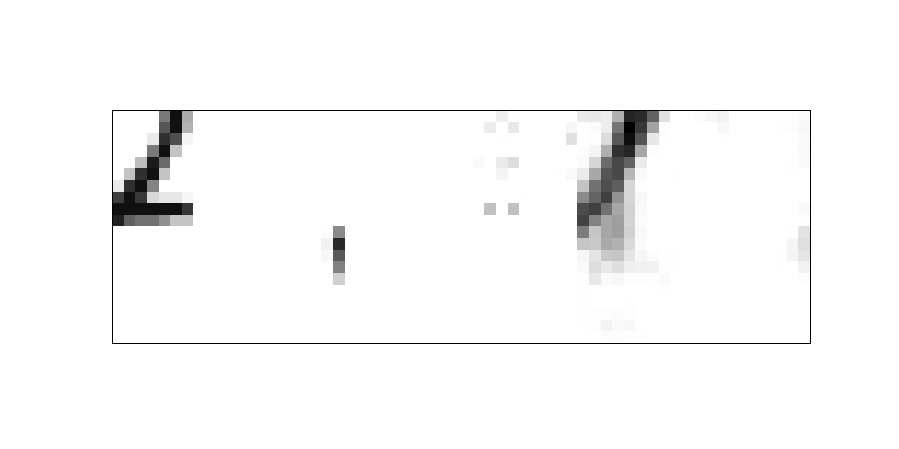

100%|██████████| 500/500 [00:01<00:00, 482.63it/s]


In [35]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_tapestry[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


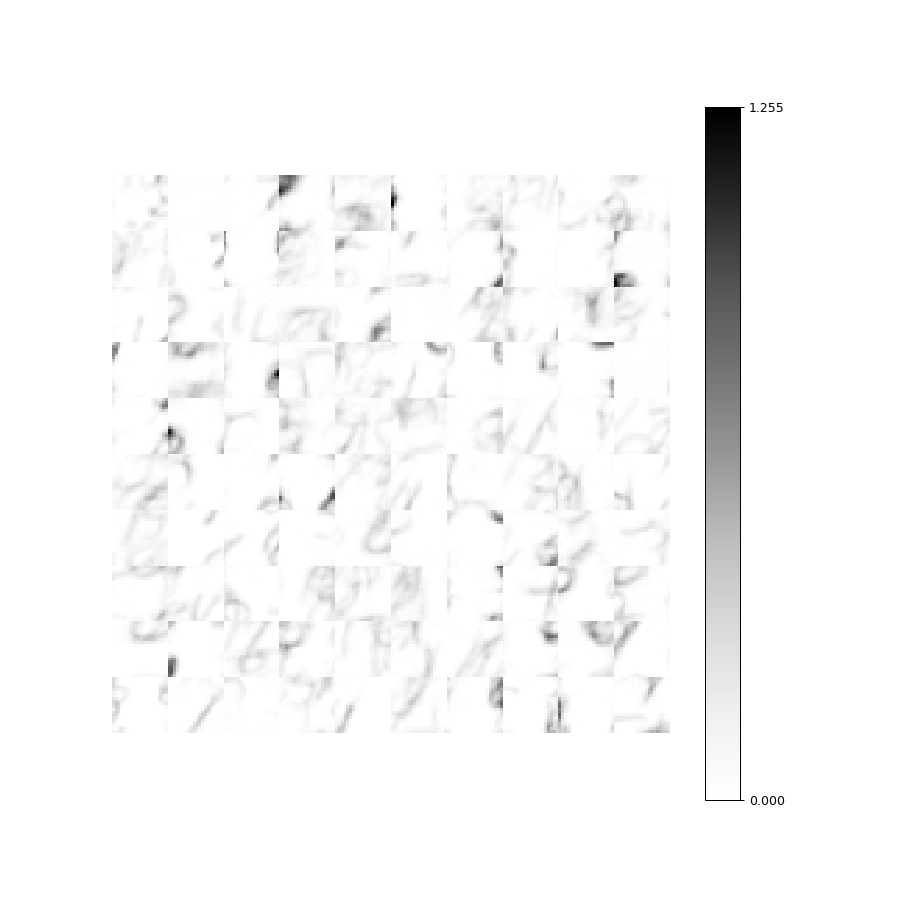

In [36]:
fig = plt.figure(figsize=(10, 10))

draw_weights((iw @ sw).get(), Ix, Iy, 20, fig)

<IPython.core.display.Javascript object>


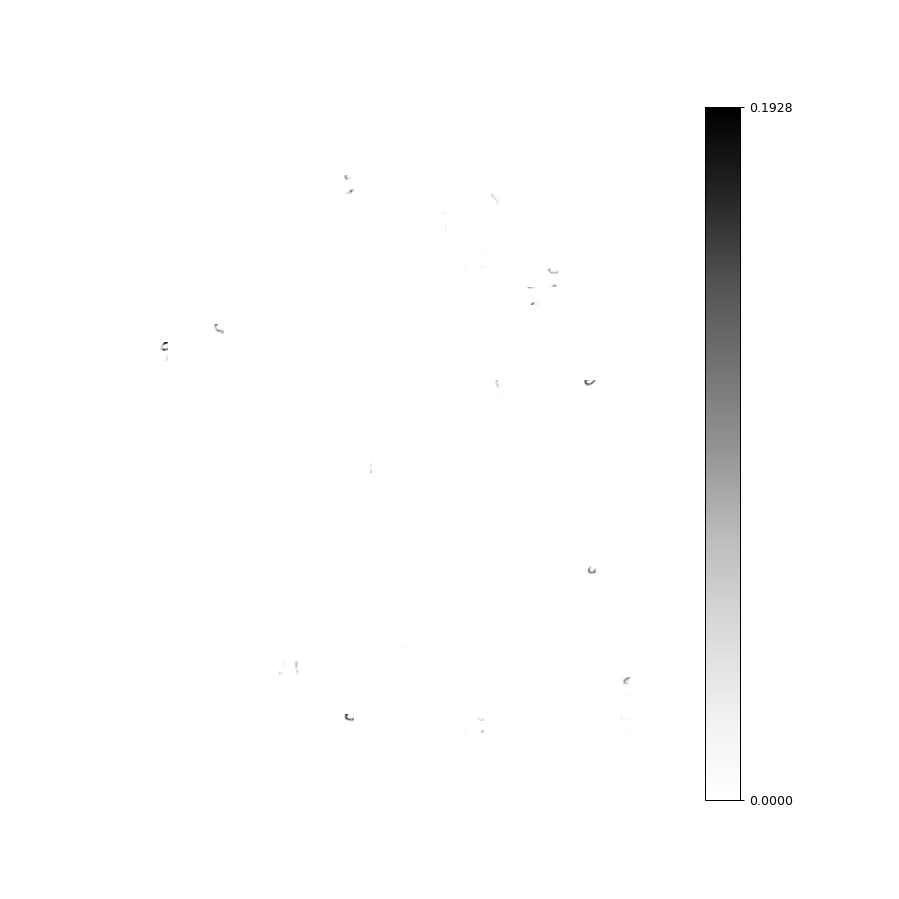

In [50]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[88].reshape(-1, 1)).get(), Kx, Ky, 20, fig)

<IPython.core.display.Javascript object>


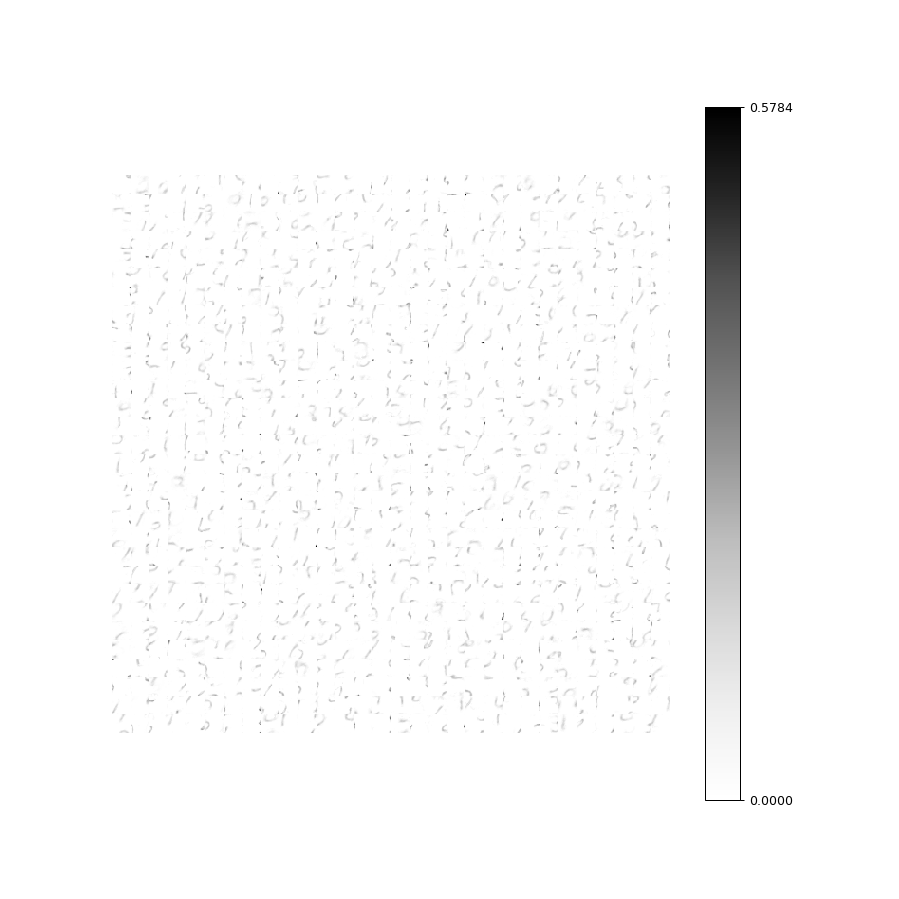

In [51]:
fig = plt.figure(figsize=(10,10))

draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


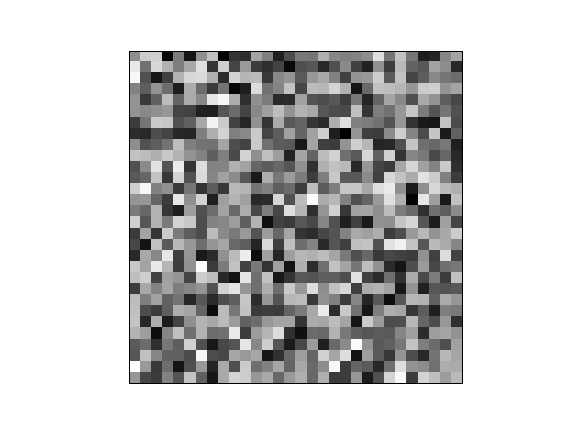

In [52]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

Hmm, I don't know how I feel about that.  

In [56]:
np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get())

229

<IPython.core.display.Javascript object>


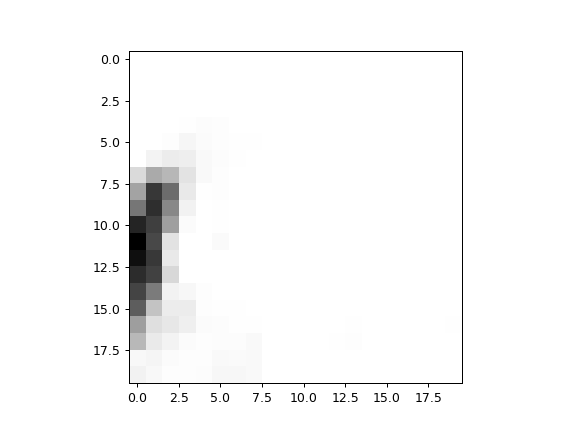

In [57]:
plt.figure()
plt.imshow(sw.get()[229].reshape(20, 20), cmap='gray_r')

I'm guessing certain prototypes aren't represented as strongly in the invariant prototypes.  Let's see which neuron is represented most strongly.

In [58]:
np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get())

840

<IPython.core.display.Javascript object>


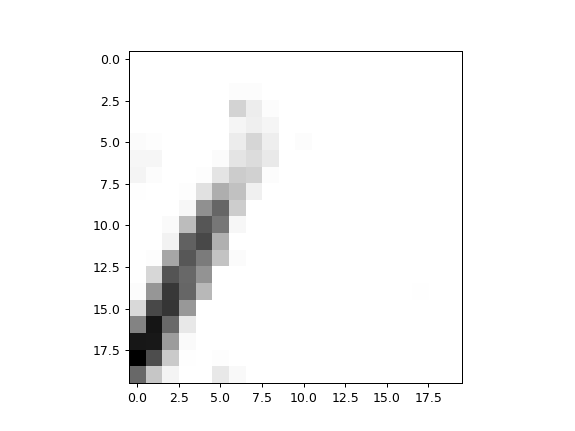

In [59]:
plt.figure()
plt.imshow(sw.get()[840].reshape(20, 20), cmap='gray_r')

Yeah, I guess I can see how that bad boi would be represented strongly.  

I'm actually pretty happy with this.  Just to see if I can mess with this in a cool way, I'm going to raise the number of winners to 4, and I'm going to lower `seta`.  I think lowering `seta` will make it harder for the network to ignore neurons.  You know, while I'm at it, I think I'll increase `leta`.  Aight, let's see what happens.

<IPython.core.display.Javascript object>


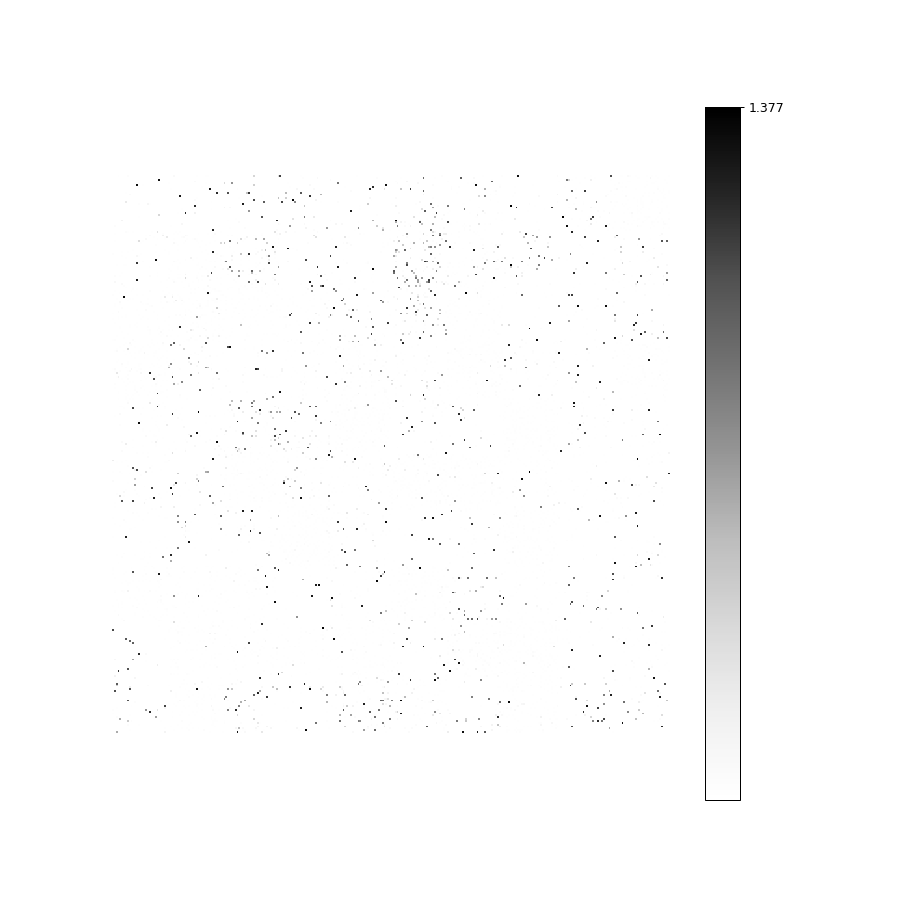

100%|██████████| 10000/10000 [00:09<00:00, 1054.06it/s]


In [60]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = sl ** 2

n_w = 4 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.03

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 0.5
leta = 0.1
seta = 0.001

for ep in range(Nep):
    inputs = gp_tapestry
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
#         print(sw.shape, v.shape)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


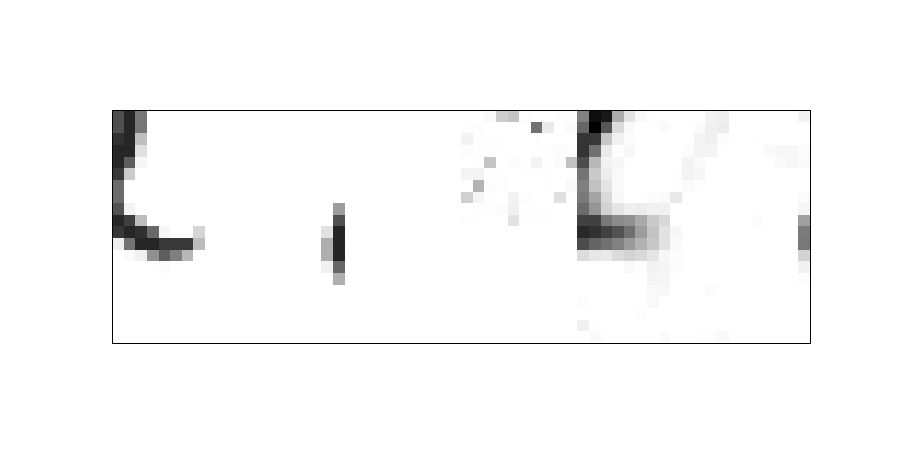

100%|██████████| 500/500 [00:01<00:00, 485.10it/s]


In [61]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_tapestry[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


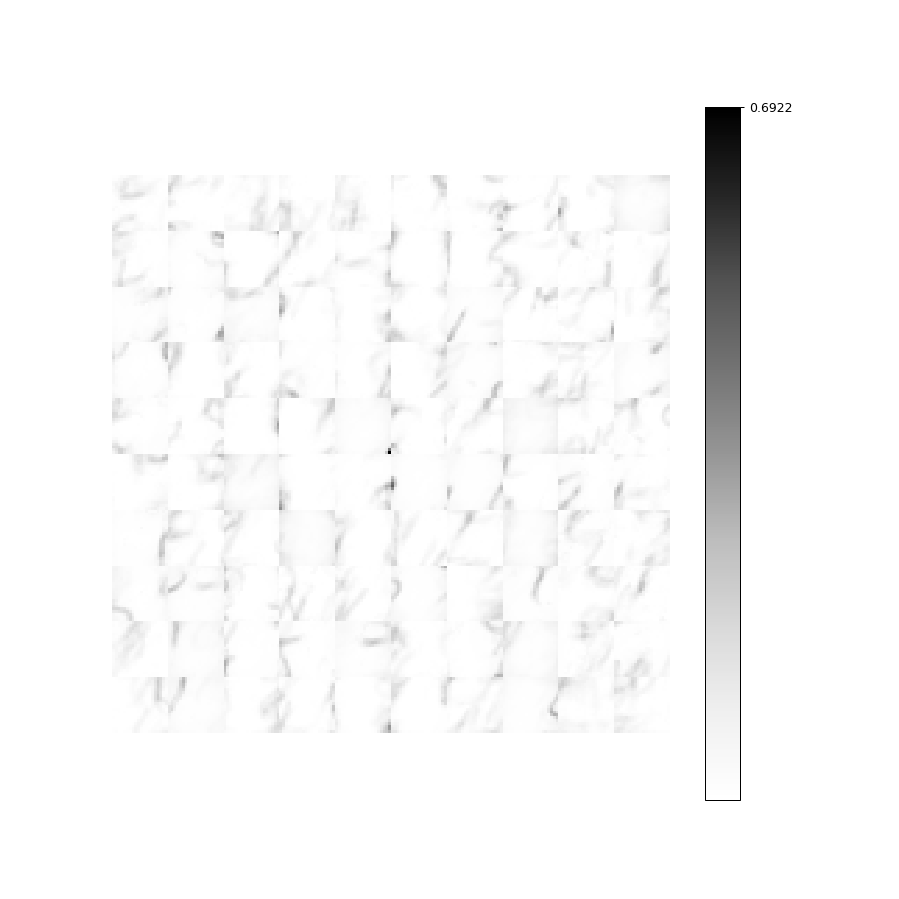

In [65]:
fig = plt.figure(figsize=(10, 10))

w_w = iw @ sw

www = w_w / cp.linalg.norm(w_w, axis=1).reshape(-1, 1)

draw_weights(www.get(), Ix, Iy, 20, fig)

<IPython.core.display.Javascript object>


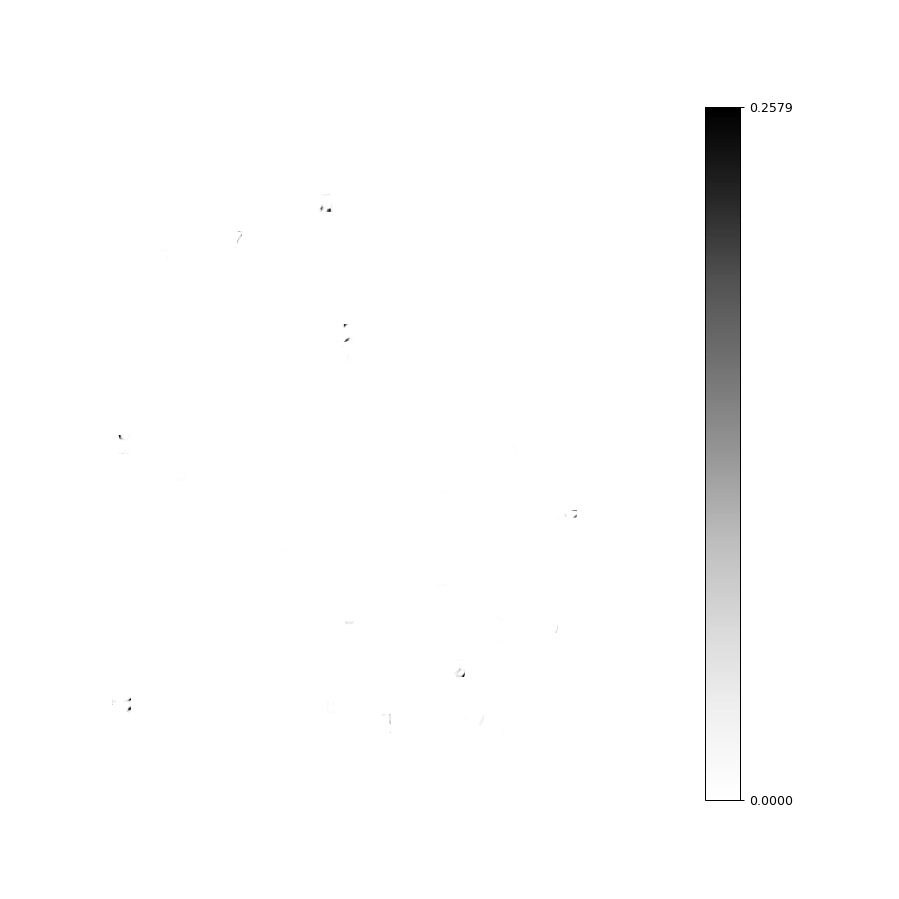

In [106]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[69].reshape(-1, 1)).get(), Kx, Ky, 20, fig)

<IPython.core.display.Javascript object>


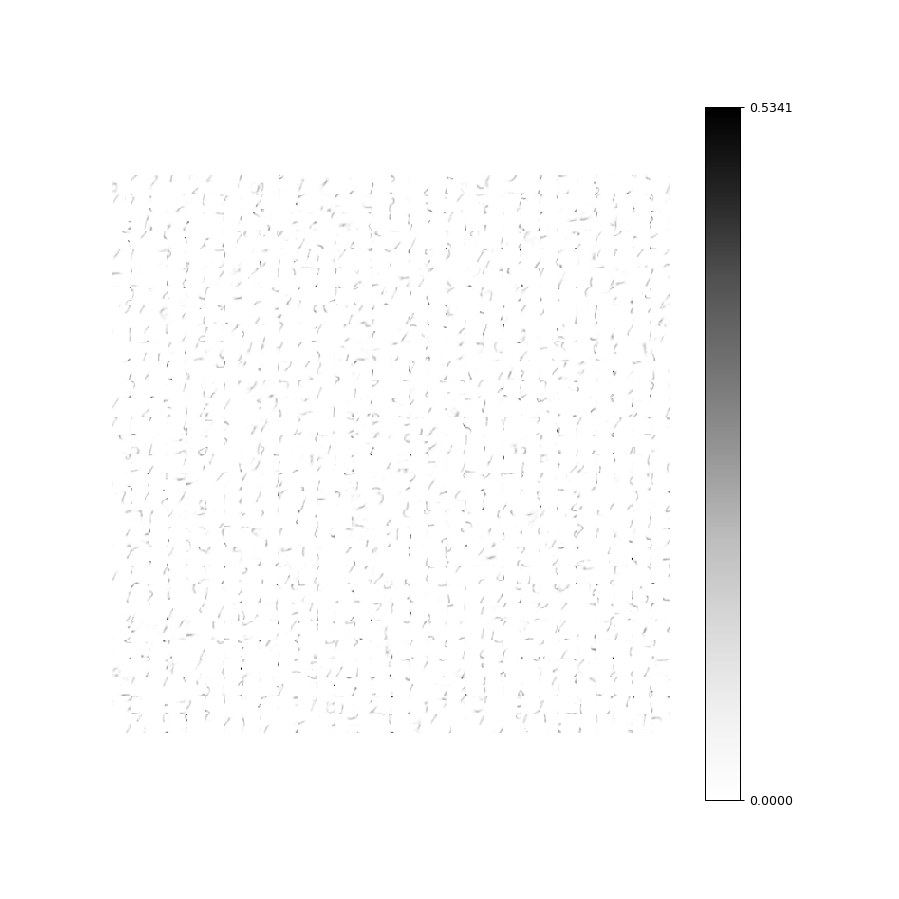

In [77]:
fig = plt.figure(figsize=(10,10))

draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


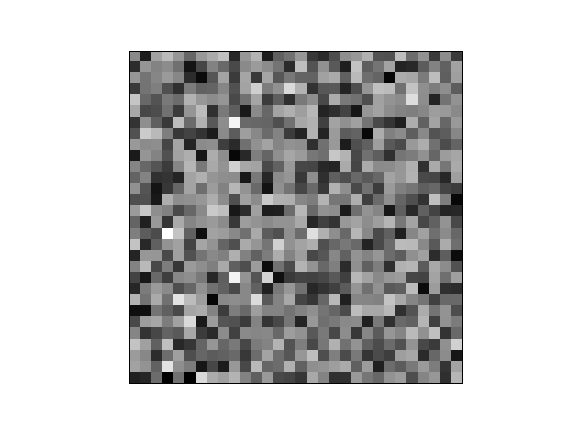

In [78]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

In [79]:
np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get())

873

<IPython.core.display.Javascript object>


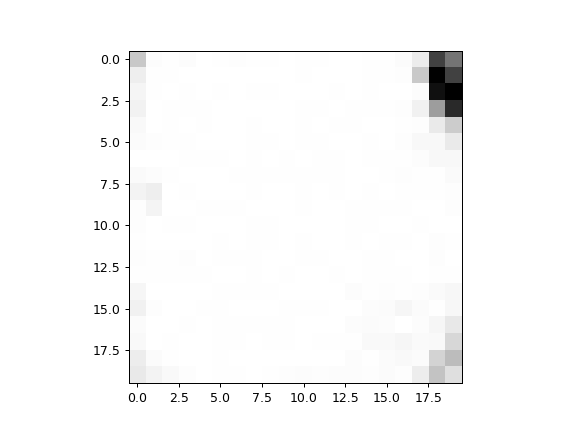

In [80]:
plt.figure()
plt.imshow(sw.get()[873].reshape(20, 20), cmap='gray_r')

In [81]:
np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get())

483

<IPython.core.display.Javascript object>


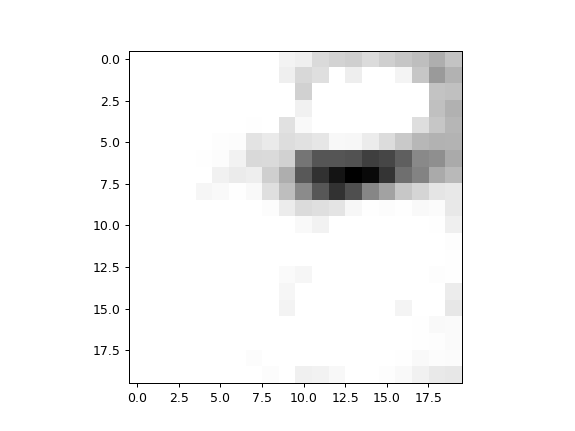

In [82]:
plt.figure()
plt.imshow(sw.get()[483].reshape(20, 20), cmap='gray_r')

Ok, I'm going to try something new.  I'm going to normalize the invariant layer every so often, and see what that does.  I'm also going to decrease the ema alpha, so that things are a bit more invariant.

Oh, and also I'm going to decrease the sparse layer's learning constant because I'm already training on a kazillion epochs, so it has time to make its prototypes darn good.

<IPython.core.display.Javascript object>


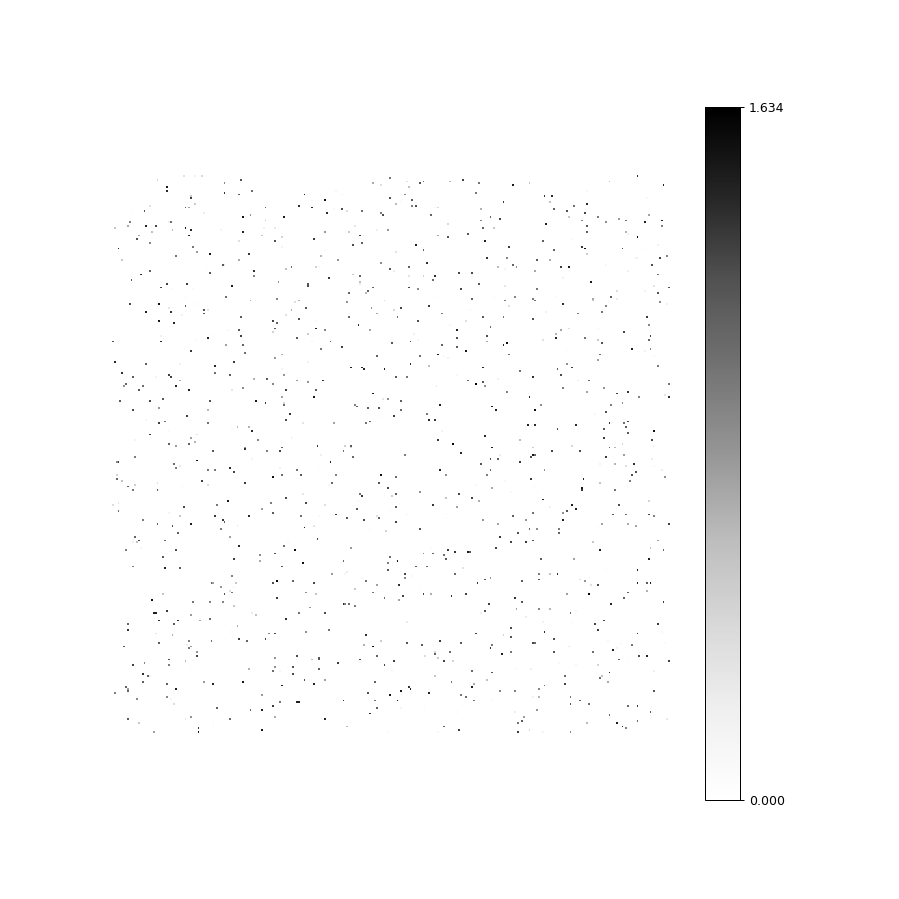

100%|██████████| 10000/10000 [00:09<00:00, 1054.25it/s]


In [109]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 30
Ky = 30
sN = Kx * Ky
m_len = sl ** 2

n_w = 4 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.008

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

iw = cp.random.uniform(0, 0.1, (iN, sN))
alpha = 2 / 6
leta = 0.1
seta = 0.001

for ep in range(Nep):
    inputs = gp_tapestry
    
    io = cp.zeros((iN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
#         print(sw.shape, v.shape)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        io_pert = iw @ so
        
        io += (io_pert - io) * alpha

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = so - r
        zeta = np.where(so > 0, leta, seta)

        iw += iw * io * ((e * zeta) / mod_r).T
        
        if i % 2000 == 0:
            iw = 9 * (iw / cp.sum(iw, axis=1).reshape(-1, 1))

    if (ep // 4) % 2 == 0:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Hmmmmmmm.  I think that might be the juice.  Let's do the analysis cell run.

<IPython.core.display.Javascript object>


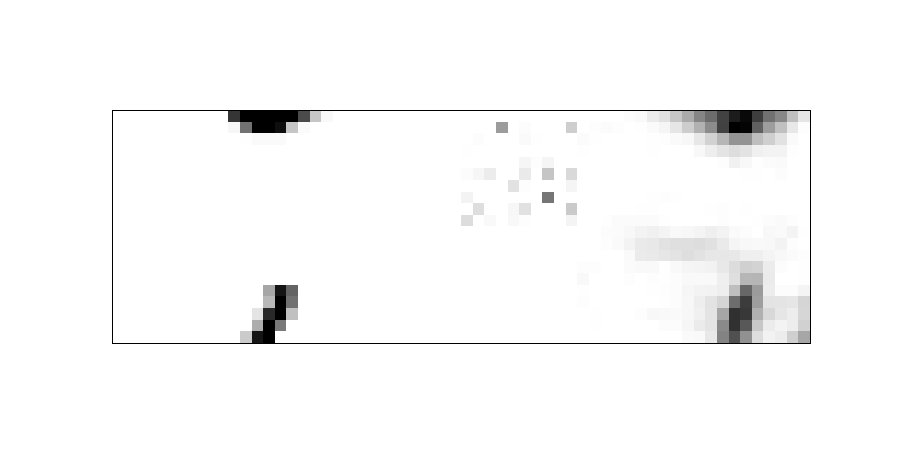

100%|██████████| 500/500 [00:01<00:00, 481.87it/s]


In [110]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_tapestry[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    io_pert = iw_np @ so

    io += (io_pert - io) * alpha
    
    mini_tap = np.zeros((20, 60))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io.reshape(glee, glee)
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


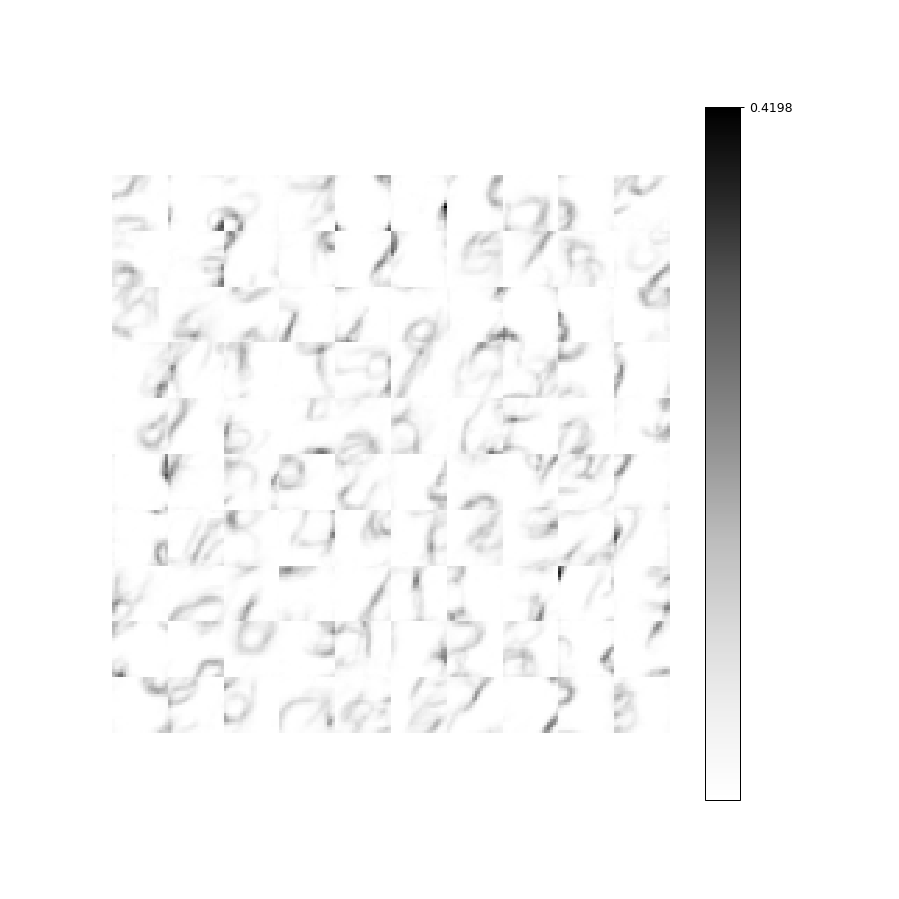

In [111]:
fig = plt.figure(figsize=(10, 10))

w_w = iw @ sw

www = w_w / cp.linalg.norm(w_w, axis=1).reshape(-1, 1)

draw_weights(www.get(), Ix, Iy, 20, fig)

<IPython.core.display.Javascript object>


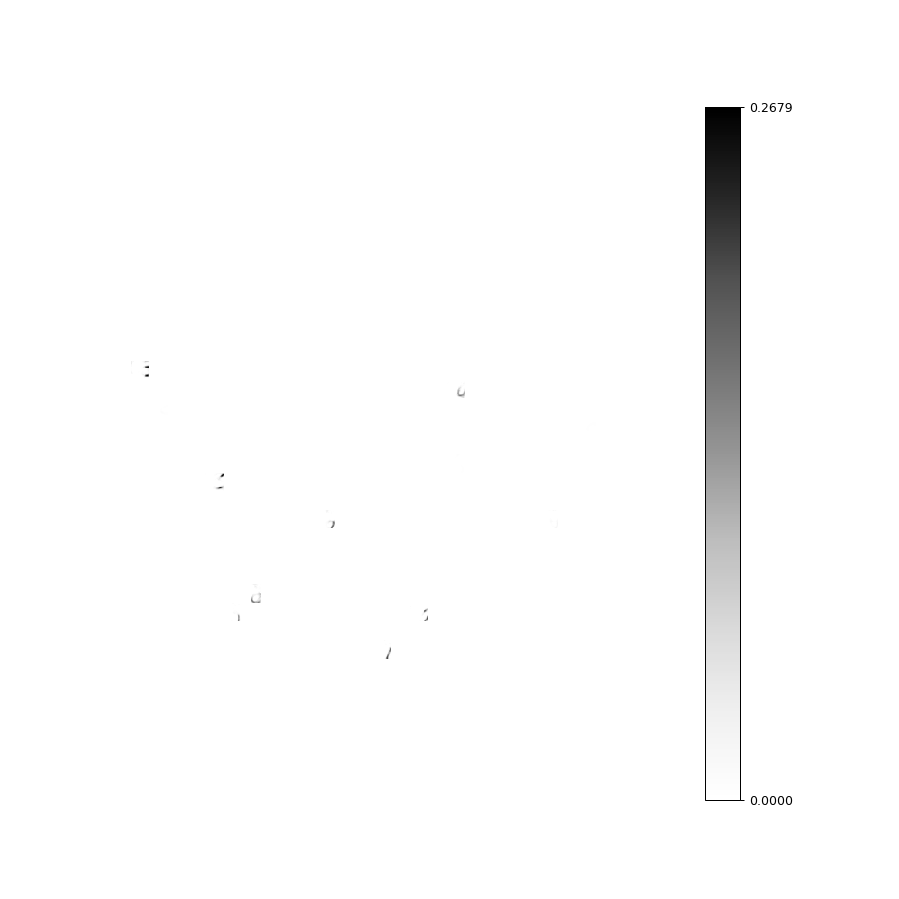

In [129]:
fig = plt.figure(figsize=(10,10))
draw_weights((sw * iw[30
                     ].reshape(-1, 1)).get(), Kx, Ky, 20, fig)

<IPython.core.display.Javascript object>


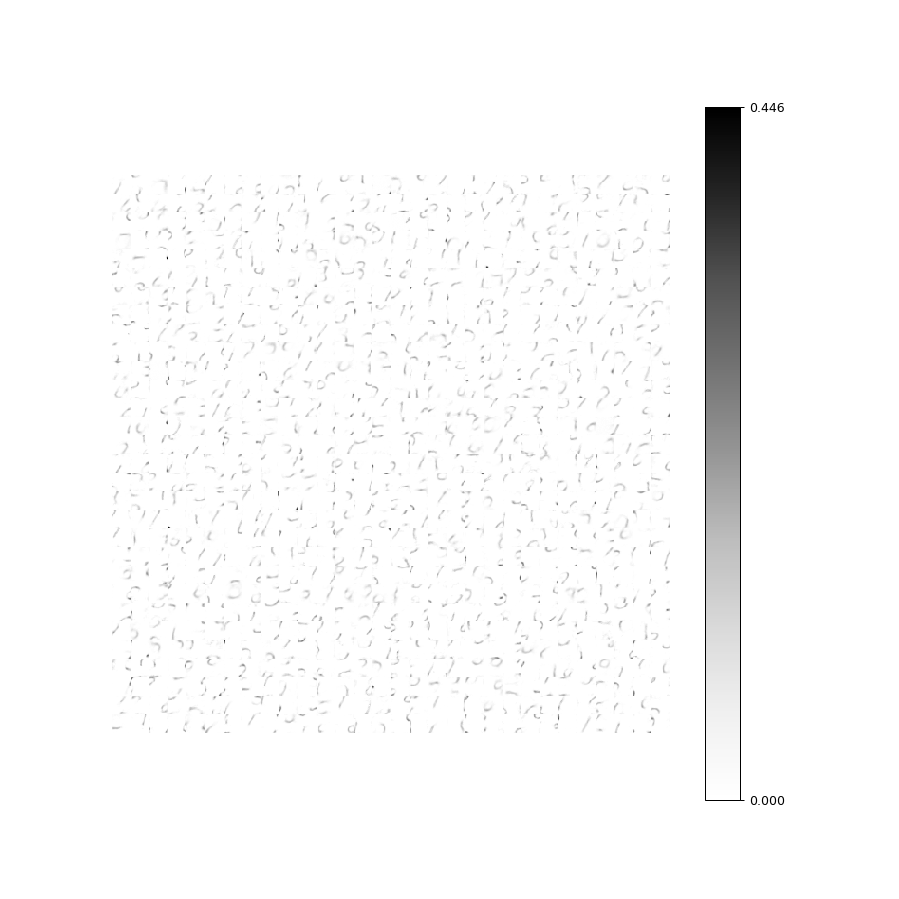

In [124]:
fig = plt.figure(figsize=(10,10))

draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


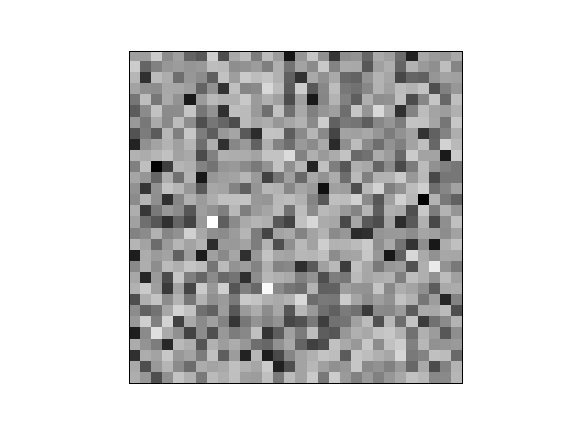

In [125]:
plt.figure()
plt.xticks([])
plt.yticks([])
plt.imshow(cp.sum(iw, axis=0).reshape(Kx, Ky).get(), cmap="gray")

<IPython.core.display.Javascript object>


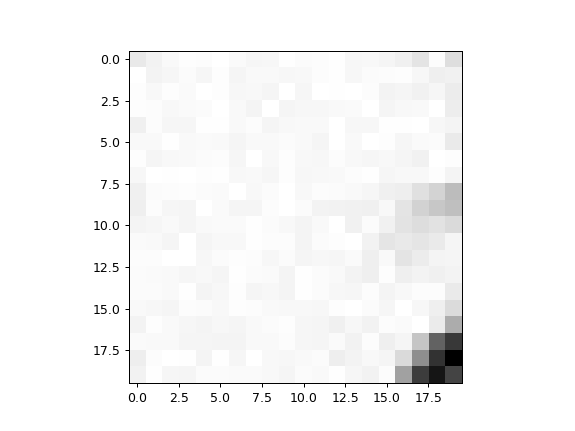

In [126]:
plt.figure()
plt.imshow(sw.get()[np.argmin(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

<IPython.core.display.Javascript object>


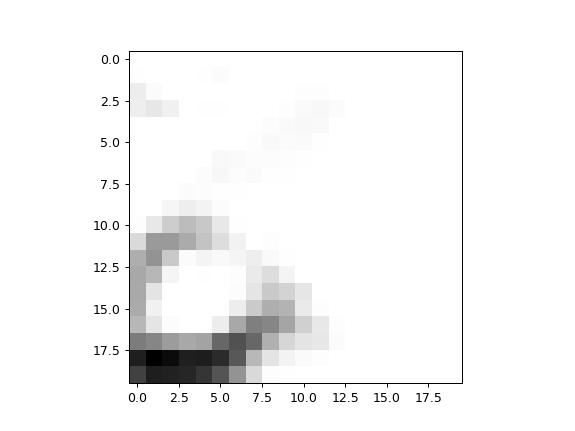

In [127]:
plt.figure()
plt.imshow(sw.get()[np.argmax(cp.sum(iw, axis=0).reshape(Kx, Ky).get())].reshape(20, 20), cmap='gray_r')

Ok, dinners ready, but this is actually pretty compelling.